<a href="https://colab.research.google.com/github/skourta/articulus_divisio/blob/part_2/Partie2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce notebook on va traiter la partie 2 du projet avec les deux datasets: "**classic4**" et "**bbc**" avec les deux représentation de mots: "**word2vec**" et "**GloVe**".
Pour chacune des datasets on va: 


*   Représenter le texte avec les deux méthodes "**word2vec**" et "**GloVe**"
*   Pour chacune des deux représentations on applique la méthode **Deep Clustering Network DCN** avec différentes valeurs du nombre de composantes, et de même pour la méthode ** Deep k-Means DKM**.
*   On récupère pour chaque cas les métrique **NMI**, **ARI**, et l'**Accuracy**. Et on affiche dans un espace réduit de 2 composantes les différents clusters



# Imports

In [1]:
%%capture
! pip install umap-learn
! gdown 'https://drive.google.com/uc?id=1zTDcgnFtQWUeXgIce4O2Z2OPn0vJH1aD'
! pip install transformers

In [2]:
from gensim.models import KeyedVectors
import numpy as np
import h5py as h5
import re
import pandas as pd
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
from umap import UMAP
from utils_py import accuracy
from wordcloud import WordCloud, STOPWORDS

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Utils

## Algorithme de classification

In [4]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

In [5]:
TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data

## Deep Clustering Network

In [6]:
class DcnCompGraph(object):
    """Computation graph for the Deep Clustering Network model proposed in:
        Yang, B., Fu, X., Sidiropoulos, N. D., & Hong, M. (2017). Towards K-means-friendly Spaces: Simultaneous Deep
        Learning and Clustering. In ICML '17 (pp. 3861–3870).
    This implementation is inspired by https://github.com/boyangumn/DCN
    """

    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(batch_size, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)

        # Clustering loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## Clustering assignments for all samples in the dataset
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)

        ## Get the cluster representative corresponding to the cluster of each batch sample
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)

        ## Compute the k-means term
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)

        # As it has been pointed out in the DCN paper, first the weights of the autoencoder shall be trained then the
        # assignments and cluster representatives. So far in the computation graph we have optimized the weights of the
        # autoencoder, now it's the time for the assignments and representatives.

        # Update the clustering assignments
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)

        # Update the cluster representatives
        ## Initialize the value of count
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=TF_FLOAT_TYPE, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

In [7]:
def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)

    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)

    # Run the computation graph
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):

                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices_, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DCN
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

            # The clustering assignments are used to initialize the clustering assignments in DCN
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))

        # Train the full DCN model
        print("Starting DCN training...")
        ## Loop over epochs
        for epoch in tqdm(range(n_finetuning_epochs)):
            # print("Training step: epoch {}".format(epoch))

            # Loop over the samples
            for _ in range(n_batches):
                # Fetch a random data batch of the specified size
                indices_, data_batch = next_batch(batch_size, data)

                # Run the computation graph on the data batch
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            # Fetch a random data batch of the specified size
            indices_, data_batch = next_batch(batch_size, data)

            # Run the computation graph on the data batch
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss,
                          cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                          feed_dict={cg.input: data_batch, cg.indices: indices_})

            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
                
    return embeddings, cluster_assign_


## Deep K-means

In [8]:
class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

In [9]:
def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

# Execution

## Read Data

In [10]:
## classic4
! gdown "https://drive.google.com/uc?id=1270jrqfjC_j9jbujB8n6bTovnqCBG1Xp"
! gdown "https://drive.google.com/uc?id=1-0eXYefFHTliAuFfrRX8g2gnkYlF3Z5H"
! gdown "https://drive.google.com/uc?id=1-DAowc4ysRC9wDy60lzs8I6FIhLE4BEb"
! gdown "https://drive.google.com/uc?id=1-ckFmuejFrNGx0mbhqwNIhewCeuOfGxs"
! gdown "https://drive.google.com/uc?id=1vKduM6oCoGWWiXZrn1P33rnu74YbJJ2T"
## bbc
! gdown "https://drive.google.com/uc?id=1--FNn99G1Uut0R1v6mFqiuBi_pG-jC6o"
! gdown "https://drive.google.com/uc?id=1-04KQb6ykGW20yXI8dSZk5YJQKT2CRGh"
! gdown "https://drive.google.com/uc?id=1-Msc4M3lNz-O0sy13iPhtQIYxw9GG3tJ"
! gdown "https://drive.google.com/uc?id=1-jbNYCPMYeOvHMlewE8KYxob8dByECye"
! gdown "https://drive.google.com/uc?id=1PSjnBVZM_hmM0jtQrZ7QNuzTeWDTPuHM"
## article1
! gdown "https://drive.google.com/uc?id=14tqs3Sf_buelaUPT1jGIpkHyu8KjR3PU"
! gdown "https://drive.google.com/uc?id=1-7vAyBn28HTFIPLaHOIHRj9AoU9E5ynK"
! gdown "https://drive.google.com/uc?id=1-FomeyJLAvsSuhI7O3QU_XOHM127b16l"
! gdown "https://drive.google.com/uc?id=1-VNnDViC5BQzngP50nGY44zMJhZ-PV7E"
! gdown "https://drive.google.com/uc?id=1HOtOrc_b9jJStW7bUFZrl5zuS9mQJwAr"
## article2
! gdown "https://drive.google.com/uc?id=1-1_vfy8YTTRg_oBNt029feNMnR_8WFJ7"
! gdown "https://drive.google.com/uc?id=1-1lSS-sRQmwb4eUt85YghMi-FWTbZjkc"
! gdown "https://drive.google.com/uc?id=1-KhATYIu3P3O8tLeszG3-qrDHtTs9Lol"
! gdown "https://drive.google.com/uc?id=1-egJzdQJL_UXQtl_De-3Q5ig-CfKNETE"
! gdown "https://drive.google.com/uc?id=1lIIkaPLSjmF57RtDy3HKTdgvrQMiQCgi"

Downloading...
From: https://drive.google.com/uc?id=1270jrqfjC_j9jbujB8n6bTovnqCBG1Xp
To: /content/classic4_word2vec.h5
100% 17.1M/17.1M [00:00<00:00, 46.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0eXYefFHTliAuFfrRX8g2gnkYlF3Z5H
To: /content/classic4_glove.h5
100% 17.1M/17.1M [00:00<00:00, 46.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-DAowc4ysRC9wDy60lzs8I6FIhLE4BEb
To: /content/classic4_bert.h5
100% 262M/262M [00:02<00:00, 94.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-ckFmuejFrNGx0mbhqwNIhewCeuOfGxs
To: /content/classic4_roberta.h5
100% 262M/262M [00:02<00:00, 93.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vKduM6oCoGWWiXZrn1P33rnu74YbJJ2T
To: /content/classic4.csv
100% 5.02M/5.02M [00:00<00:00, 15.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--FNn99G1Uut0R1v6mFqiuBi_pG-jC6o
To: /content/bbc_word2vec.h5
100% 2.70M/2.70M [00:00<00:00, 86.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-04KQb

In [11]:
classic4_word2vec = pd.read_hdf("classic4_word2vec.h5").to_numpy()
classic4_glove = pd.read_hdf("classic4_glove.h5").to_numpy()
classic4_bert = pd.read_hdf("classic4_bert.h5").to_numpy()
classic4_roberta = pd.read_hdf("classic4_roberta.h5").to_numpy()
bbc_word2vec = pd.read_hdf("bbc_word2vec.h5").to_numpy()
bbc_glove = pd.read_hdf("bbc_glove.h5").to_numpy()
bbc_bert = pd.read_hdf("bbc_bert.h5").to_numpy()
bbc_roberta = pd.read_hdf("bbc_roberta.h5").to_numpy()
articles1_word2vec = pd.read_hdf("articles1_word2vec.h5").to_numpy()
articles1_glove = pd.read_hdf("articles1_glove.h5").to_numpy()
articles1_bert = pd.read_hdf("articles1_bert.h5").to_numpy()
articles1_roberta = pd.read_hdf("articles1_roberta.h5").to_numpy()
articles2_word2vec = pd.read_hdf("articles2_word2vec.h5").to_numpy()
articles2_glove = pd.read_hdf("articles2_glove.h5").to_numpy()
articles2_bert = pd.read_hdf("articles2_bert.h5").to_numpy()
articles2_roberta = pd.read_hdf("articles2_roberta.h5").to_numpy()

In [12]:
classic4_texts = pd.read_csv("classic4.csv")["text"].values
bbc_texts = pd.read_csv("bbc.csv")["text"].values
articles1_texts = pd.read_csv("articles1.csv", sep=";")["text"].values
articles2_texts = pd.read_csv("articles2.csv", sep="\t")["text"].values
classic4_labels = pd.read_csv("classic4.csv")["label"].values
bbc_labels = pd.read_csv("bbc.csv")["label"].values
k_classic4 = len(set(classic4_labels))
k_bbc = len(set(bbc_labels))

## Utils

In [13]:
def map_labels(labels):
    mapping = {}
    for (i,name) in enumerate(set(labels)):
        mapping[name] = i
    return [mapping[letter] for letter in labels]

In [14]:
def eval_clustering_2D(x, labels, pred_labels, methods):
    fig, axes = plt.subplots(1, len(pred_labels)+1, figsize=(20,10))
    axes[0].scatter(x[:,0], x[:,1],
                    c=labels, edgecolor='none', alpha=1,)
    axes[0].title.set_text('Real Labels')
    nmis, aris, accs = {}, {}, {}
    for i in range(len(pred_labels)):
        nmi = normalized_mutual_info_score(labels, pred_labels[i])
        ari = adjusted_rand_score(labels, pred_labels[i])
        acc = accuracy(labels, pred_labels[i])
        nmis[methods[i]] = nmi
        aris[methods[i]] = ari
        accs[methods[i]] = acc
        axes[i+1].scatter(x[:,0], x[:,1],
                    c=pred_labels[i], edgecolor='none', alpha=1,)
        axes[i+1].title.set_text('{}\nNMI = {:.6f}\nARI={:.6f}\nACC={:.6f}'.format(methods[i], nmi, ari, acc))
    
    return nmis, aris, accs

In [15]:
def run_methods(func, X, k, method_name, file_name, dataset, rep, ns = [2, 3, 5, 10, 20, 50]):
  print(f'Executing of {method_name} method on the dataset: "{dataset}" with {rep} representation.')
  ALG_labels, ALG_methods = [], []
  for n_components in ns:
    print('Number of components:', n_components)
    alg_embeddings, alg_labels = func(X, k, n_components, seed=n_components)
    ALG_labels.append(alg_labels), ALG_methods.append(f'{method_name} - n_components = {n_components}')
    with h5.File(file_name, 'a') as alg_file:
      alg_file.create_dataset(f'{dataset}_default{n_components}components_embed_{rep}', data=alg_embeddings)
      alg_file.create_dataset(f'{dataset}_default{n_components}components_labels_{rep}', data=alg_labels)
  return ALG_labels, ALG_methods

In [16]:
def print_wordcloud(X, labels):
    temp_df = pd.DataFrame({
        "text": X,
        "labels": labels
    })
    for label in temp_df['labels'].unique():
        alltext = ' '.join(temp_df[temp_df['labels']== label]['text'])
        wordcloud = WordCloud().generate(alltext)
        # Display the generated image:
        print(f'Class: {label}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        print(f'\n')

## Clasic4

In [24]:
dataset = 'classic4'
k = k_classic4
labels = classic4_labels
classic4_resluts = {}

### Word2Vec

In [26]:
X = classic4_word2vec
rep = 'word2vec'

#### DCN

In [27]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with word2vec representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.37it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:46<00:00,  1.06it/s]


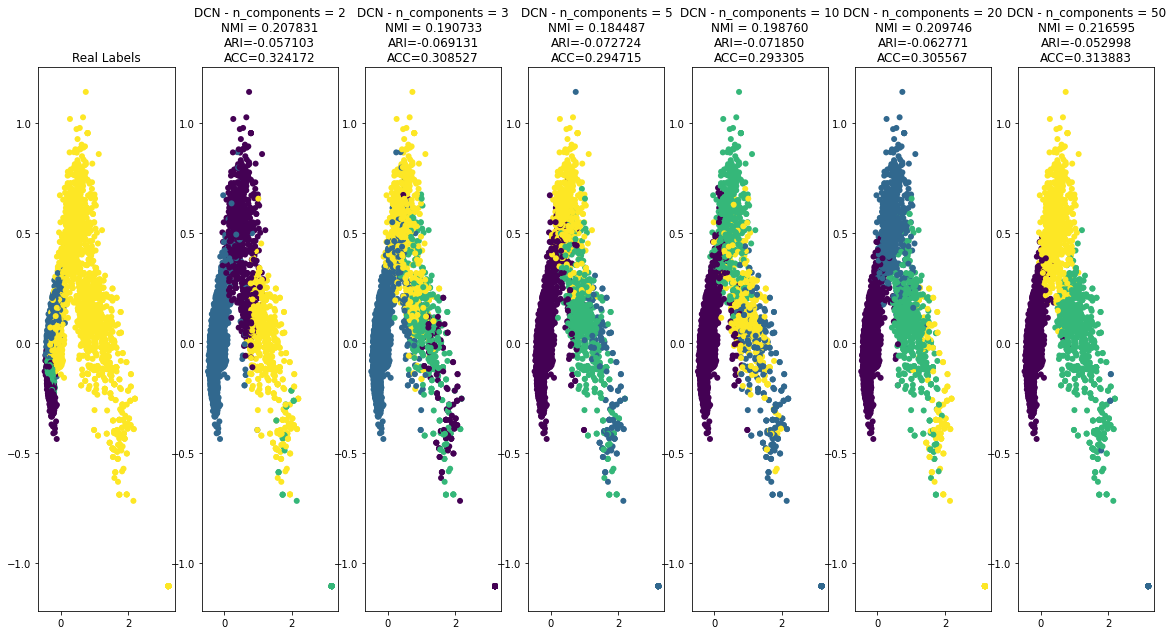

In [28]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Pour la dataset '**classic4**', on peut voir sur la visualisation de l'espace de la représentation **word2vec** après la réduction de la dimension que les clusters ne sont pas facilement séparable, et qu'en augmentant le nombre de composantes à chaque fois ne fait pas trop améliorer la qualité de notre classification. Les différentes combinaisons de la méthodes DCN avec différentes nombre de composantes ne sont pas donc capables de séparer les classes dans leur espace d'origine, car la plupart d'entre elles sont proches de l'estimation aléatoire des étiquettes (ARI proche de 0 ou <0)


In [29]:
key = '{}_{}_dcn'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

#### DKM

In [30]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic4" with word2vec representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.23it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:30<00:00,  1.53s/it]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.22it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


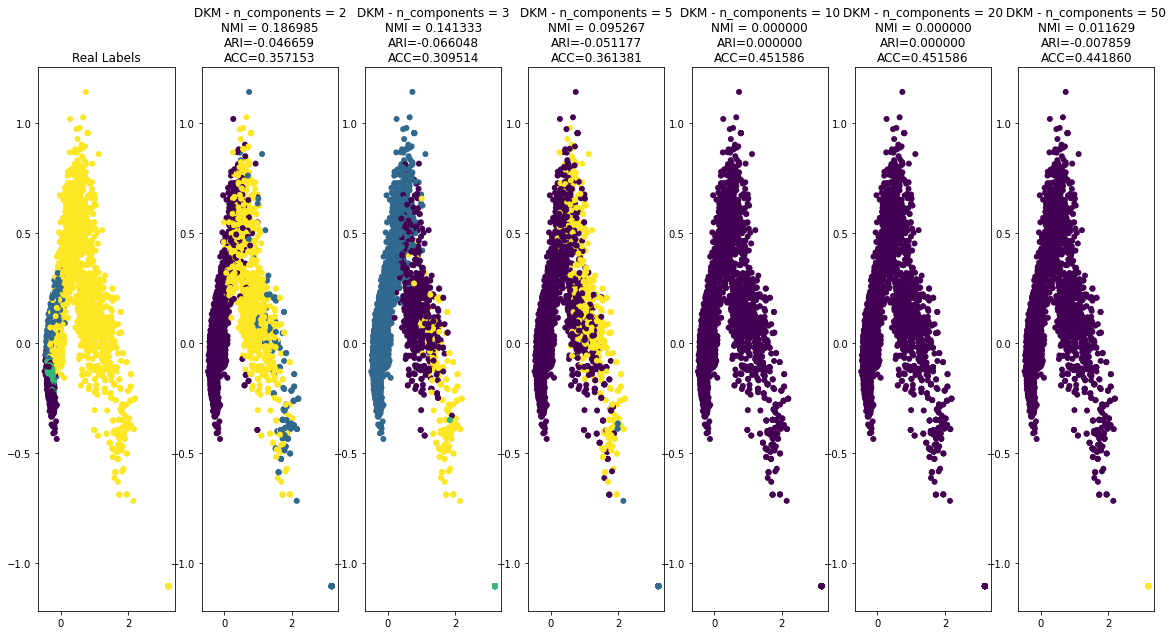

In [31]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Pour la même représentation **word2vec** et en appliquant la méthode DKM avec différents nombre de composantes, on peut voir que la classification proposée avec 2 composantes est toujours dans les mêmes performances que celles du DCN, en augmentant l'ARI vers 0.3. On constate également qu'en augmentant le nombre de composantes à chaque fois ne fait que dégrader les perofrmances de la classification sur toutes les mesures.

In [32]:
key = '{}_{}_dkm'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

### GloVe

In [33]:
X = classic4_glove
rep = 'GloVe'

#### DCN

In [34]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with GloVe representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.38it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.31it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


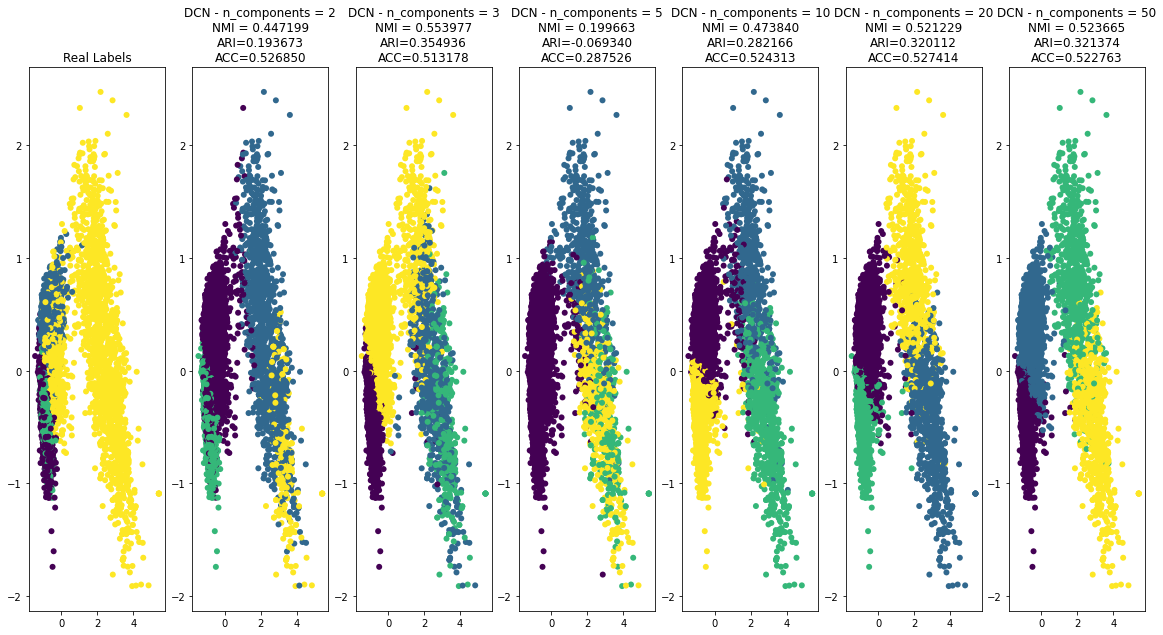

In [35]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Pour la même dataset, on peut voir sur la visualisation de l'espace de la représentation **GloVe** après la réduction de la dimension que les clusters ne sont pas facilement séparable, et qu'à chaque augmentation du nombre de composantes on aura une amélioration la qualité de notre classification. Les différentes combinaisons de la méthodes **DCN** avec différentes nombre de composantes étaient capable de mieux séparer les classes dans leurs espace d'origine par rapport à ce qu'on a vu dans dans la représentation '**word2vec**', et ça peut se confirmer en observant la valeur de l'ARI qui est presque toujouts aux alentours de **0.5**


In [36]:
key = '{}_{}_dcn'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

#### DKM

In [37]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "classic4" with GloVe representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.11it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.27it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:32<00:00,  1.64s/it]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.29it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:11<00:00,  4.24it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


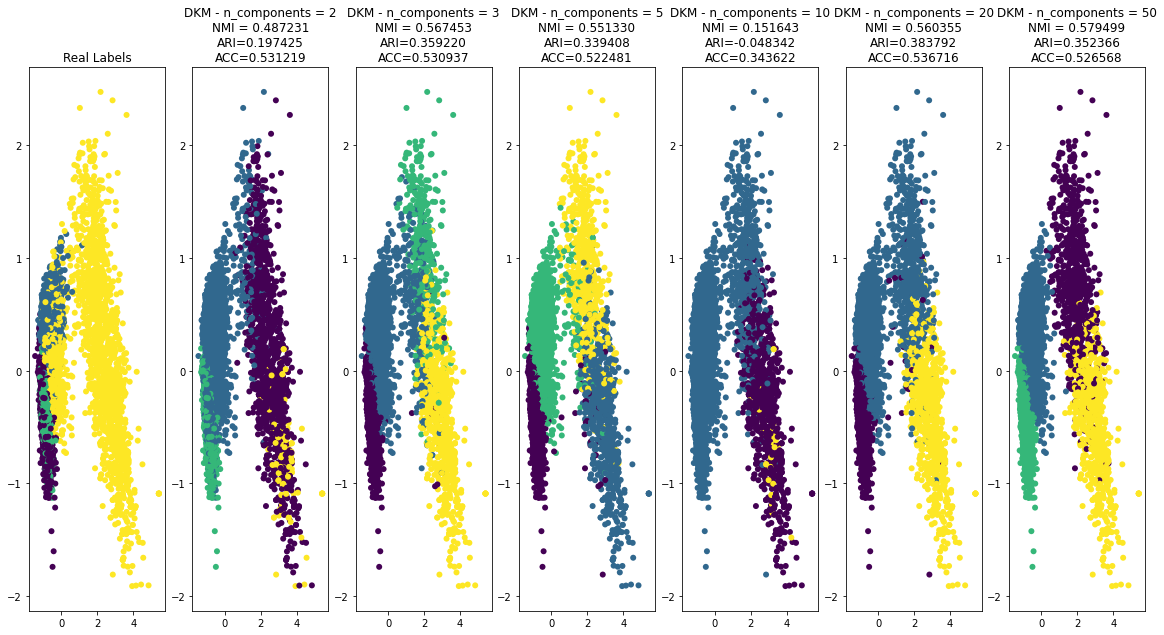

In [38]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Pour la même représentation, on remarque que les différentes combinaisons de la méthodes **DKM** avec différentes nombre de composantes étaient capable de bien séparer les classes dans leurs espace d'origine, on a eu des exemples la meilleure classification dans ce jeu de données avec un nombre de composantes égale à 3, et ça peut se confirmer en observant la valeur de sont ARI=**0.37** avec un NMI=**0.56** et une accuracy=**0.51**


In [39]:
key = '{}_{}_dkm'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

### Bert

In [40]:
X = classic4_bert
rep = 'bert'

#### DCN

In [41]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with bert representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:46<00:00,  2.12s/it]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


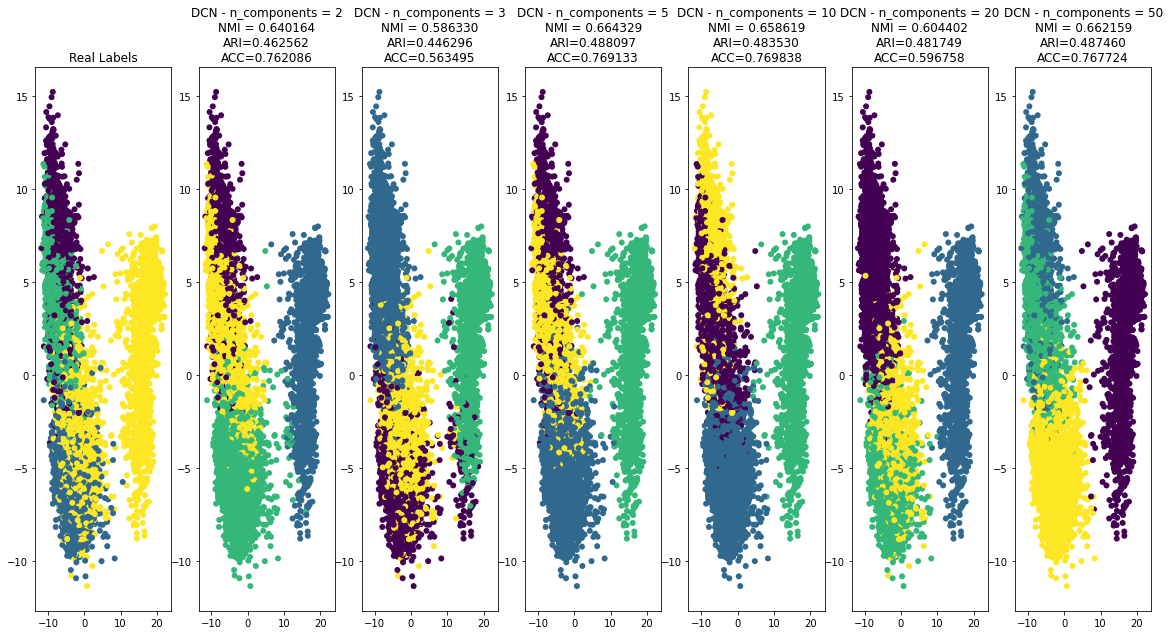

In [42]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Pour la dataset '**classic4**', on peut voir sur la visualisation de l'espace de la représentation **word2vec** après la réduction de la dimension que les clusters ne sont pas facilement séparable, et qu'en augmentant le nombre de composantes à chaque fois ne fait pas trop améliorer la qualité de notre classification. Les différentes combinaisons de la méthodes DCN avec différentes nombre de composantes ne sont pas donc capables de séparer les classes dans leur espace d'origine, car la plupart d'entre elles sont proches de l'estimation aléatoire des étiquettes (ARI proche de 0 ou <0)


In [43]:
key = '{}_{}_dcn'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Pour la même représentation **word2vec** et en appliquant la méthode DKM avec différents nombre de composantes, on peut voir que la classification proposée avec 2 composantes est toujours dans les mêmes performances que celles du DCN, en augmentant l'ARI vers 0.3. On constate également qu'en augmentant le nombre de composantes à chaque fois ne fait que dégrader les perofrmances de la classification sur toutes les mesures.

In [ ]:
key = '{}_{}_dkm'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

### RoBertA

In [44]:
X = classic4_roberta
rep = 'roberta'

#### DCN

In [45]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "classic4" with roberta representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:47<00:00,  2.14s/it]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:46<00:00,  2.14s/it]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:14<00:00,  1.49s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


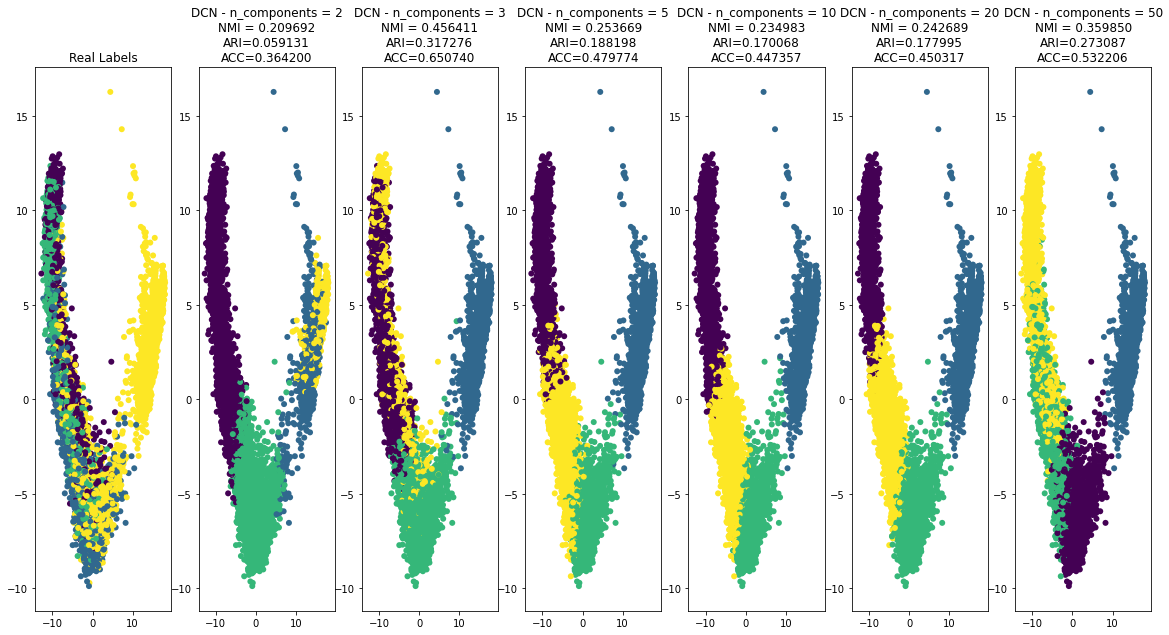

In [46]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Pour la dataset '**classic4**', on peut voir sur la visualisation de l'espace de la représentation **word2vec** après la réduction de la dimension que les clusters ne sont pas facilement séparable, et qu'en augmentant le nombre de composantes à chaque fois ne fait pas trop améliorer la qualité de notre classification. Les différentes combinaisons de la méthodes DCN avec différentes nombre de composantes ne sont pas donc capables de séparer les classes dans leur espace d'origine, car la plupart d'entre elles sont proches de l'estimation aléatoire des étiquettes (ARI proche de 0 ou <0)


In [47]:
key = '{}_{}_dcn'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Pour la même représentation **word2vec** et en appliquant la méthode DKM avec différents nombre de composantes, on peut voir que la classification proposée avec 2 composantes est toujours dans les mêmes performances que celles du DCN, en augmentant l'ARI vers 0.3. On constate également qu'en augmentant le nombre de composantes à chaque fois ne fait que dégrader les perofrmances de la classification sur toutes les mesures.

In [ ]:
key = '{}_{}_dkm'.format(dataset, rep)
classic4_resluts[key] = (nmis, aris, accs)

### Tableau des résultats

In [48]:
with open("/gdrive/My Drive/datasets/AMSD/projet_nadif/classic4part2results.pkl", "wb") as results_file:
  pickle.dump(classic4_resluts, results_file)

In [49]:
CLASSIC4_results = {key: {inkey: {'nmi': nmi[inkey],'ari': ari[inkey],'acc': acc[inkey]} for inkey in nmi.keys()}  for key, (nmi, ari, acc) in classic4_resluts.items()}
classic4_results_dataframe = pd.DataFrame.from_dict({(i,j): CLASSIC4_results[i][j] 
                           for i in CLASSIC4_results.keys() 
                           for j in CLASSIC4_results[i].keys()},
                       orient='index')
classic4_results_dataframe

nmi       ari       acc
classic4_word2vec_dcn DCN - n_components = 2   2.078308e-01 -0.057103  0.324172
                      DCN - n_components = 3   1.907327e-01 -0.069131  0.308527
                      DCN - n_components = 5   1.844874e-01 -0.072724  0.294715
                      DCN - n_components = 10  1.987599e-01 -0.071850  0.293305
                      DCN - n_components = 20  2.097457e-01 -0.062771  0.305567
                      DCN - n_components = 50  2.165948e-01 -0.052998  0.313883
classic4_word2vec_dkm DKM - n_components = 2   1.869847e-01 -0.046659  0.357153
                      DKM - n_components = 3   1.413331e-01 -0.066048  0.309514
                      DKM - n_components = 5   9.526700e-02 -0.051177  0.361381
                      DKM - n_components = 10  1.728046e-15  0.000000  0.451586
                      DKM - n_components = 20  1.728046e-15  0.000000  0.451586
                      DKM - n_components = 50  1.162880e-02 -0.007859  0.441860
classic4_GloVe_dcn    DCN - n_components = 2   4.471995e-01  0.193673  0.526850
                      DCN - n_components = 3   5.539772e-01  0.354936  0.513178
                      DCN - n_components = 5   1.996633e-01 -0.069340  0.287526
                      DCN - n_components = 10  4.738405e-01  0.282166  0.524313
                      DCN - n_components = 20  5.212286e-01  0.320112  0.527414
                      DCN - n_components = 50  5.236652e-01  0.321374  0.522763
classic4_GloVe_dkm    DKM - n_components = 2   4.872314e-01  0.197425  0.531219
                      DKM - n_components = 3   5.674530e-01  0.359220  0.530937
                      DKM - n_components = 5   5.513299e-01  0.339408  0.522481
                      DKM - n_components = 10  1.516430e-01 -0.048342  0.343622
                      DKM - n_components = 20  5.603550e-01  0.383792  0.536716
                      DKM - n_components = 50  5.794994e-01  0.352366  0.526568
classic4_bert_dcn     DCN - n_components = 2   6.401638e-01  0.462562  0.762086
                      DCN - n_components = 3   5.863304e-01  0.446296  0.563495
                      DCN - n_components = 5   6.643293e-01  0.488097  0.769133
                      DCN - n_components = 10  6.586193e-01  0.483530  0.769838
                      DCN - n_components = 20  6.044024e-01  0.481749  0.596758
                      DCN - n_components = 50  6.621592e-01  0.487460  0.767724
classic4_roberta_dcn  DCN - n_components = 2   2.096919e-01  0.059131  0.364200
                      DCN - n_components = 3   4.564110e-01  0.317276  0.650740
                      DCN - n_components = 5   2.536686e-01  0.188198  0.479774
                      DCN - n_components = 10  2.349834e-01  0.170068  0.447357
                      DCN - n_components = 20  2.426888e-01  0.177995  0.450317
                      DCN - n_components = 50  3.598497e-01  0.273087  0.532206

Meilleure méthode selon la métrique NMI:

In [50]:
metric = "nmi"
classic4_results_dataframe[classic4_results_dataframe[metric] == classic4_results_dataframe[metric].max()]

nmi       ari       acc
classic4_bert_dcn DCN - n_components = 5  0.664329  0.488097  0.769133

Meilleure méthode selon la métrique ARI:

In [51]:
metric = "ari"
classic4_results_dataframe[classic4_results_dataframe[metric] == classic4_results_dataframe[metric].max()]

nmi       ari       acc
classic4_bert_dcn DCN - n_components = 5  0.664329  0.488097  0.769133

Meilleure méthode selon la métrique l'Accuracy:

In [52]:
metric = "acc"
classic4_results_dataframe[classic4_results_dataframe[metric] == classic4_results_dataframe[metric].max()]

nmi      ari       acc
classic4_bert_dcn DCN - n_components = 10  0.658619  0.48353  0.769838

### Nuage des points

DCN 5 composantes - BERT 

Class: 1


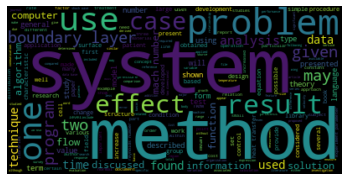



Class: 0


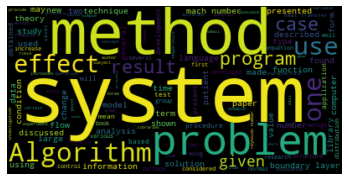



Class: 4


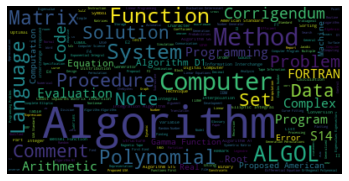

In [59]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
dataset, n_components, rep = 'classic4', 5, 'bert'
cluster_key = f'{dataset}_default{n_components}components_embed_{rep}'
with h5.File(file_name, 'r') as alg_file:
  best_labels = alg_file[cluster_key]
  print_wordcloud(classic4_texts, np.array(best_labels).argmax(axis=1))

DCN - 10 composantes - Bert

Class: 4


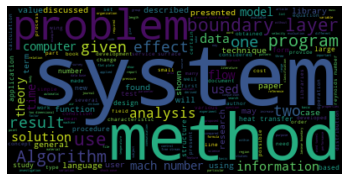



Class: 3


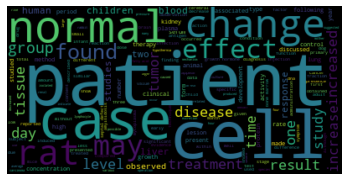



Class: 0


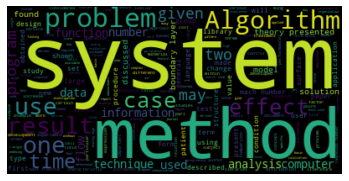

In [60]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
dataset, n_components, rep = 'classic4', 10, 'bert'
cluster_key = f'{dataset}_default{n_components}components_embed_{rep}'
with h5.File(file_name, 'r') as alg_file:
  best_labels = alg_file[cluster_key]
  print_wordcloud(classic4_texts, np.array(best_labels).argmax(axis=1))

Class: cacm


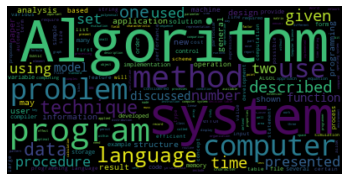



Class: cisi


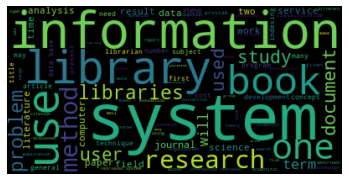



Class: med


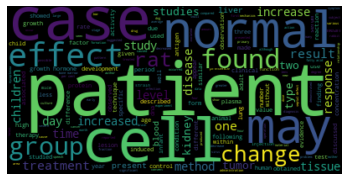



Class: cran


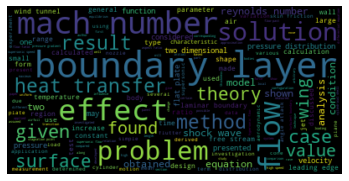

In [55]:
print_wordcloud(classic4_texts, classic4_labels)

## BBC

In [22]:
dataset = 'bbc'
k = k_bbc
labels = bbc_labels
bbc_resluts = {}

### Word2Vec

In [23]:
X = bbc_word2vec
rep = 'word2vec'

#### DCN

In [24]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "bbc" with word2vec representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:05<00:00,  9.96it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.80it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.69it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.66it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.47it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.07it/s]


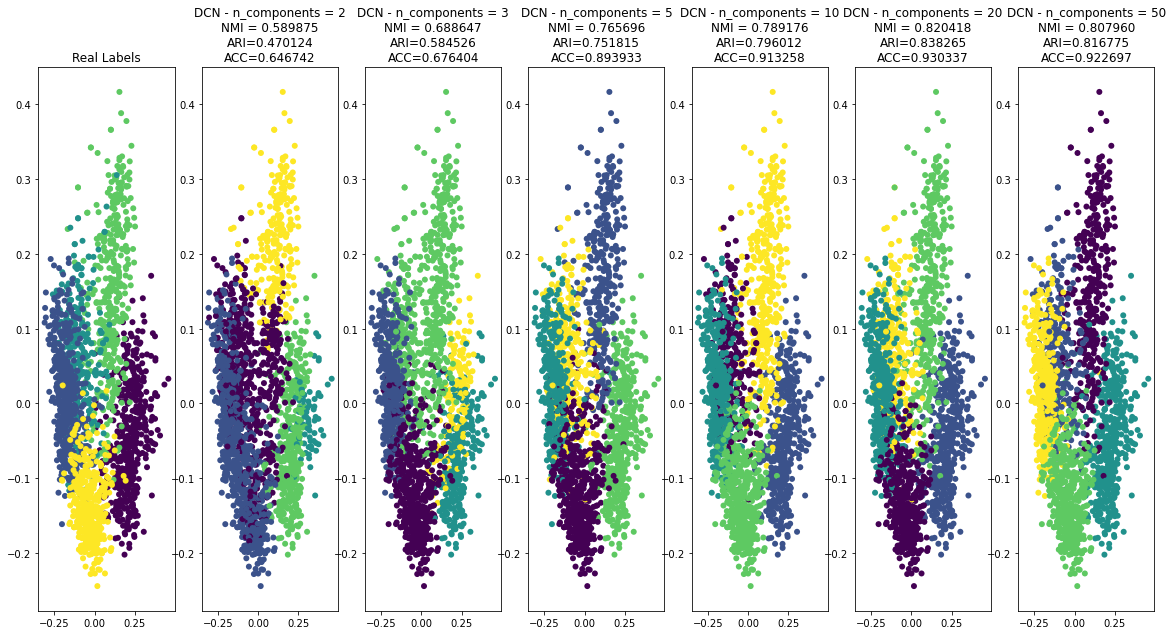

In [25]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Pour la dataset '**bbc**' avec la représnetation '**word2vec**' et tn visualisant l'espace en utilisant l'ACP à 2 dimensions, on peut voir que les classes sont difficiles à séparer. 

Les résultats ci-dessus montrent que la méthode **DCN** nous a donné de bons résultats de classfication dès la première exécution (avec nombre de composantes égale à 2). On observe également qu'à chaque qu'on augmente le nombre de composantes, on aura des améliorations dans les résultats, cela peut être confirmé à travers les 3 métriques qui ne cessent d'augmenter à chaque fois.

In [26]:
key = '{}_{}_dcn'.format(dataset, rep)
bbc_resluts[key] = (nmis, aris, accs)

#### DKM

In [27]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "bbc" with word2vec representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.89it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 14.08it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 14.30it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 14.06it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


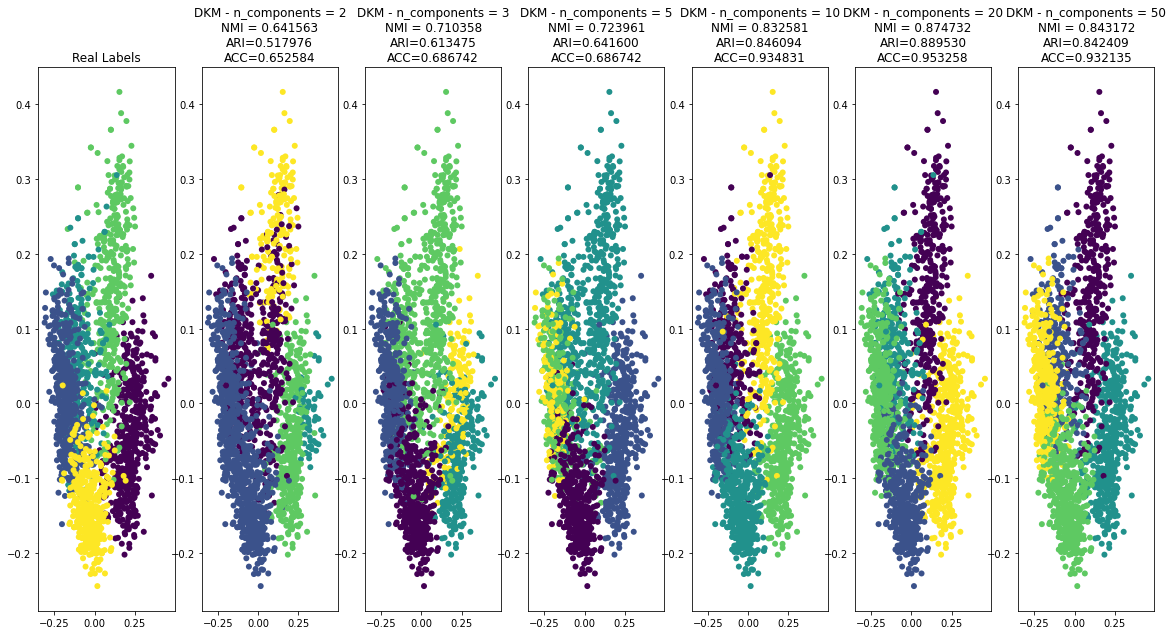

In [28]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Pour la même représentation **word2vec** et en appliquant la méthode **DKM** avec différents nombre de composantes, on peut voir que la classification proposée était toujours mieux que celle obtenue par **DCN** avec le même nombre de composantes. Cela peut remarqué à travers les graphes de visualisations et à travers les 3 métriques (**NMI**, **ARI** et **Accuracy**)

In [29]:
key = '{}_{}_dkm'.format(dataset, rep)
bbc_resluts[key] = (nmis, aris, accs)

### GloVe

In [30]:
X = bbc_glove
rep = 'GloVe'

#### DCN

In [31]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "bbc" with GloVe representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.90it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.73it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.64it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.88it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:11<00:00,  4.20it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.72it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.17it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.39it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


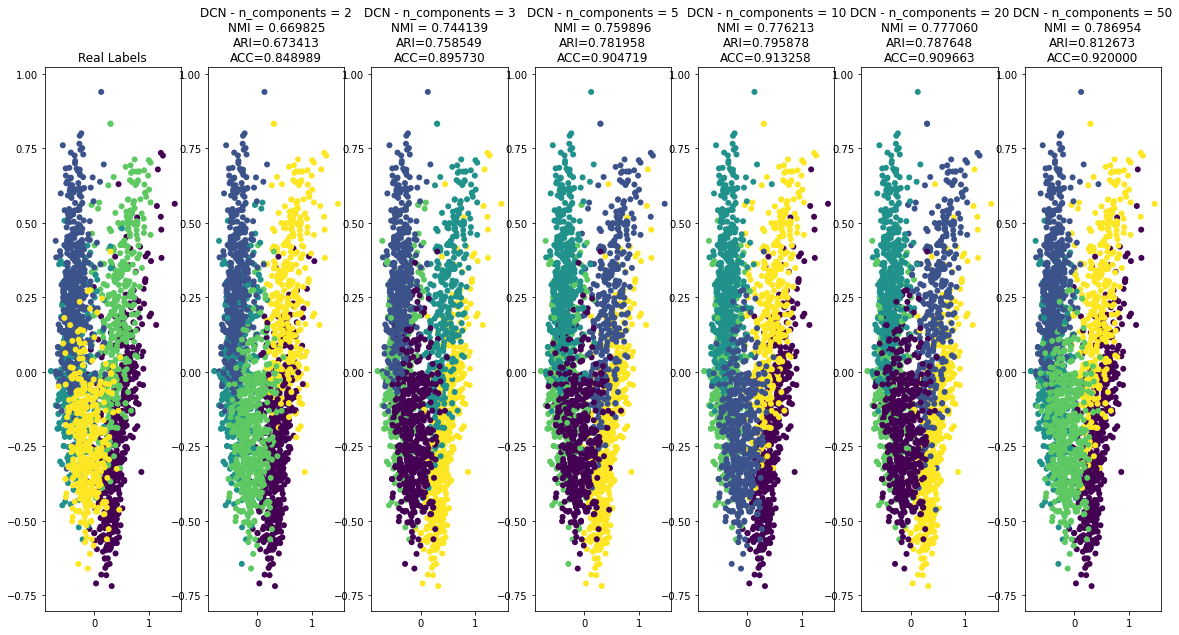

In [32]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Pour la même dataset '**bbc**' et avec la représnetation '**GloVe**' et en visualisant l'espace en utilisant l'ACP à 2 dimensions, on peut voir que les classes sont difficiles à séparer. 

Les résultats ci-dessus montrent que la méthode **DCN** nous a donné de bons résultats de classfication dès la première exécution (avec nombre de composantes égale à 2). On observe également qu'à chaque qu'on augmente le nombre de composantes, on aura des améliorations dans les résultats, cela peut être confirmé à travers les 3 métriques qui ne cessent d'augmenter à chaque fois. Les résultats sont presque simliaires par rapprot à ceux qu'on a obtenus avec la représentation **word2vec**

In [33]:
key = '{}_{}_dcn'.format(dataset, rep)
bbc_resluts[key] = (nmis, aris, accs)

#### DKM

In [34]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "bbc" with GloVe representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.86it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 14.06it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 14.03it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 14.34it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 14.30it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:03<00:00, 13.99it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


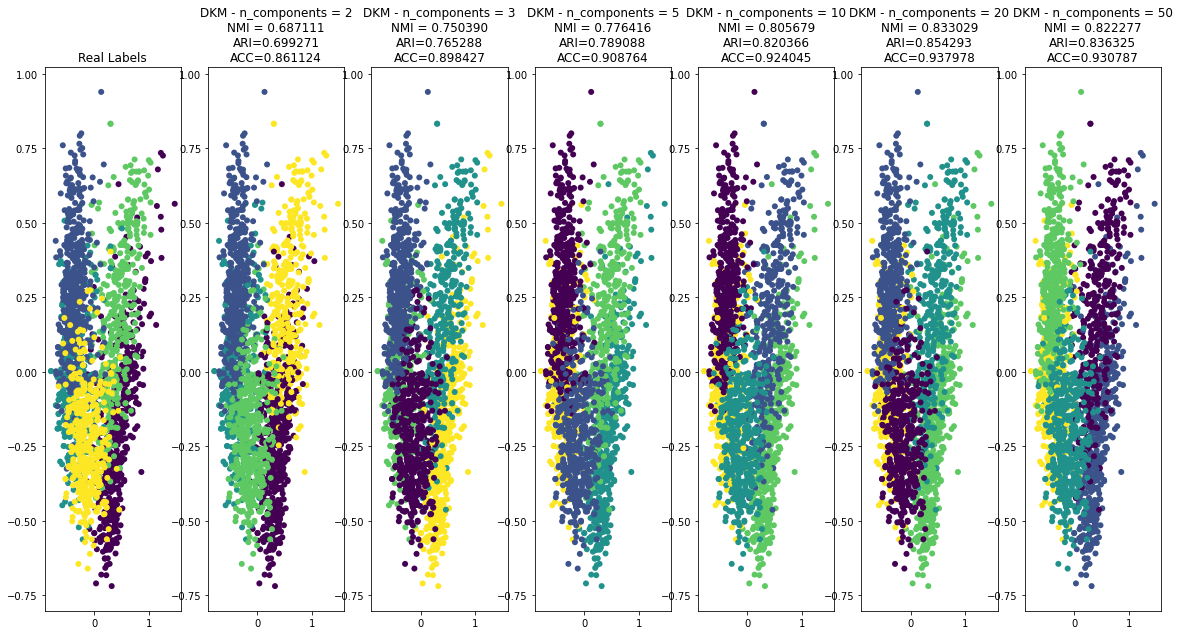

In [35]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

On peut faire la même remarque qu'auparavant, c'est à dire que la méthode **DKM** donne de meilleurs résultats par rapport à **DCN** avec le même ensemble de données. Et que pour cette dataset **bbc** les résultats sont presque similaires avec les deux représentations des mots (**word2vec** ou **GloVe**).

In [36]:
key = '{}_{}_dkm'.format(dataset, rep)
bbc_resluts[key] = (nmis, aris, accs)

### Bert

In [37]:
X = bbc_bert
rep = 'bert'

#### DCN

In [38]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "bbc" with bert representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.27it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


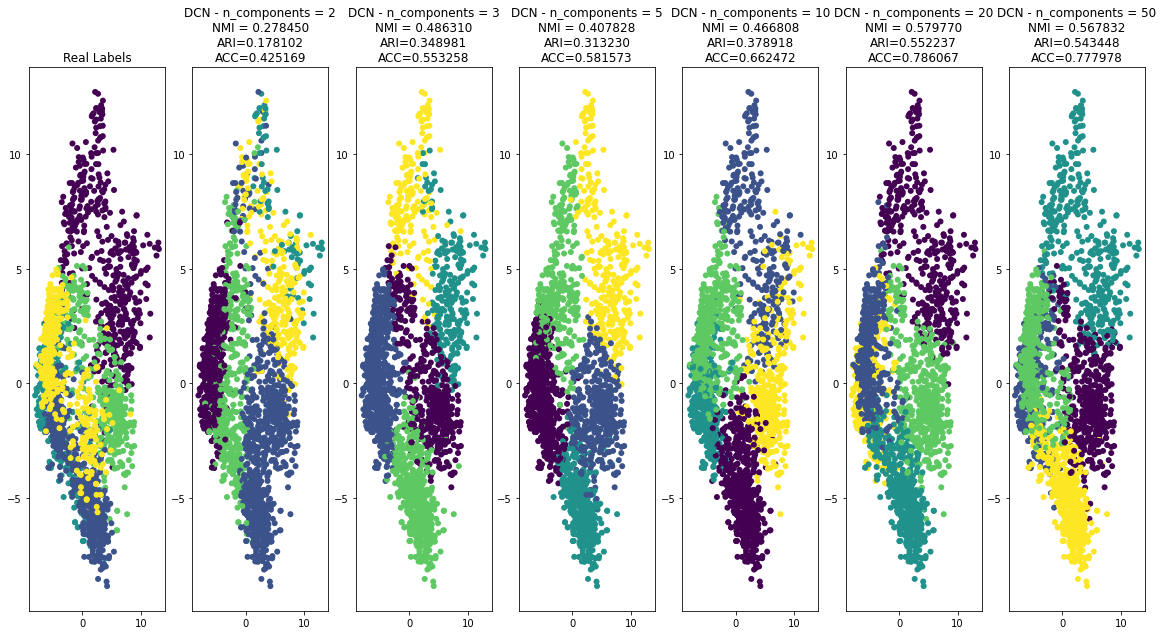

In [39]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Pour la dataset '**classic4**', on peut voir sur la visualisation de l'espace de la représentation **word2vec** après la réduction de la dimension que les clusters ne sont pas facilement séparable, et qu'en augmentant le nombre de composantes à chaque fois ne fait pas trop améliorer la qualité de notre classification. Les différentes combinaisons de la méthodes DCN avec différentes nombre de composantes ne sont pas donc capables de séparer les classes dans leur espace d'origine, car la plupart d'entre elles sont proches de l'estimation aléatoire des étiquettes (ARI proche de 0 ou <0)


In [40]:
key = '{}_{}_dcn'.format(dataset, rep)
bbc_resluts[key] = (nmis, aris, accs)

#### DKM

In [41]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "bbc" with bert representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:46<00:00,  2.34s/it]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


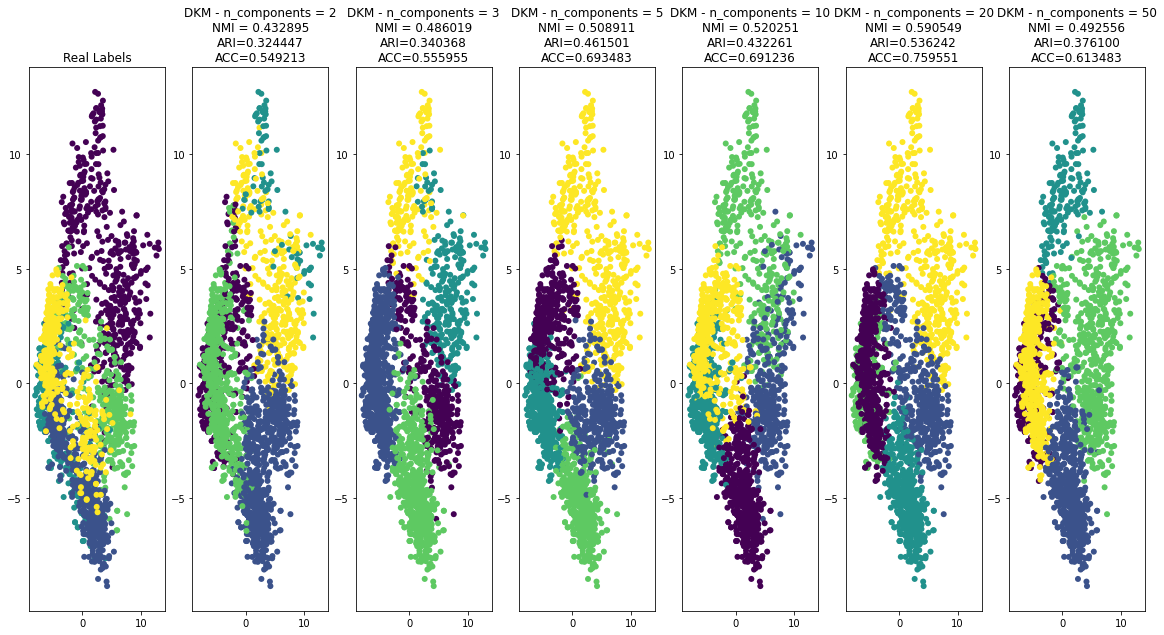

In [42]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Pour la même représentation **word2vec** et en appliquant la méthode DKM avec différents nombre de composantes, on peut voir que la classification proposée avec 2 composantes est toujours dans les mêmes performances que celles du DCN, en augmentant l'ARI vers 0.3. On constate également qu'en augmentant le nombre de composantes à chaque fois ne fait que dégrader les perofrmances de la classification sur toutes les mesures.

In [43]:
key = '{}_{}_dkm'.format(dataset, rep)
bbc_resluts[key] = (nmis, aris, accs)

### RoBertA

In [44]:
X = bbc_roberta
rep = 'roberta'

#### DCN

In [45]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

Executing of DCN method on the dataset: "bbc" with roberta representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:32<00:00,  1.53it/s]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


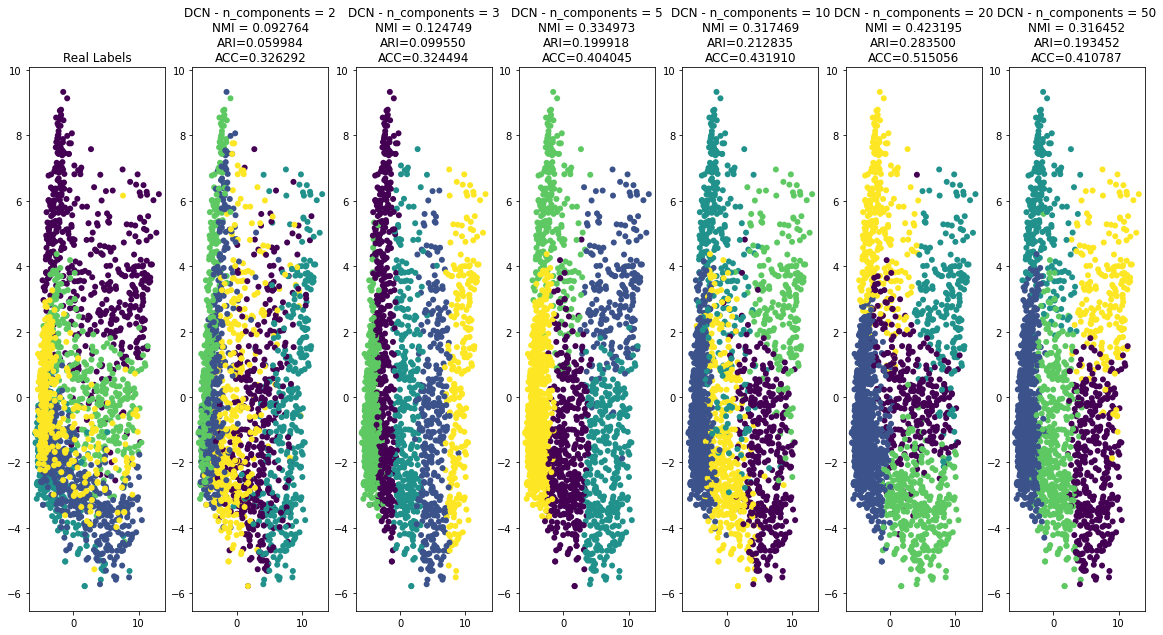

In [46]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

Pour la dataset '**classic4**', on peut voir sur la visualisation de l'espace de la représentation **word2vec** après la réduction de la dimension que les clusters ne sont pas facilement séparable, et qu'en augmentant le nombre de composantes à chaque fois ne fait pas trop améliorer la qualité de notre classification. Les différentes combinaisons de la méthodes DCN avec différentes nombre de composantes ne sont pas donc capables de séparer les classes dans leur espace d'origine, car la plupart d'entre elles sont proches de l'estimation aléatoire des étiquettes (ARI proche de 0 ou <0)


In [47]:
key = '{}_{}_dcn'.format(dataset, rep)
bbc_resluts[key] = (nmis, aris, accs)

#### DKM

In [48]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

Executing of DKM method on the dataset: "bbc" with roberta representation.
Number of components: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


Number of components: 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:46<00:00,  2.35s/it]


Number of components: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:21<00:00,  2.27it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


Number of components: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


Number of components: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:22<00:00,  2.26it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


Number of components: 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:47<00:00,  2.37s/it]


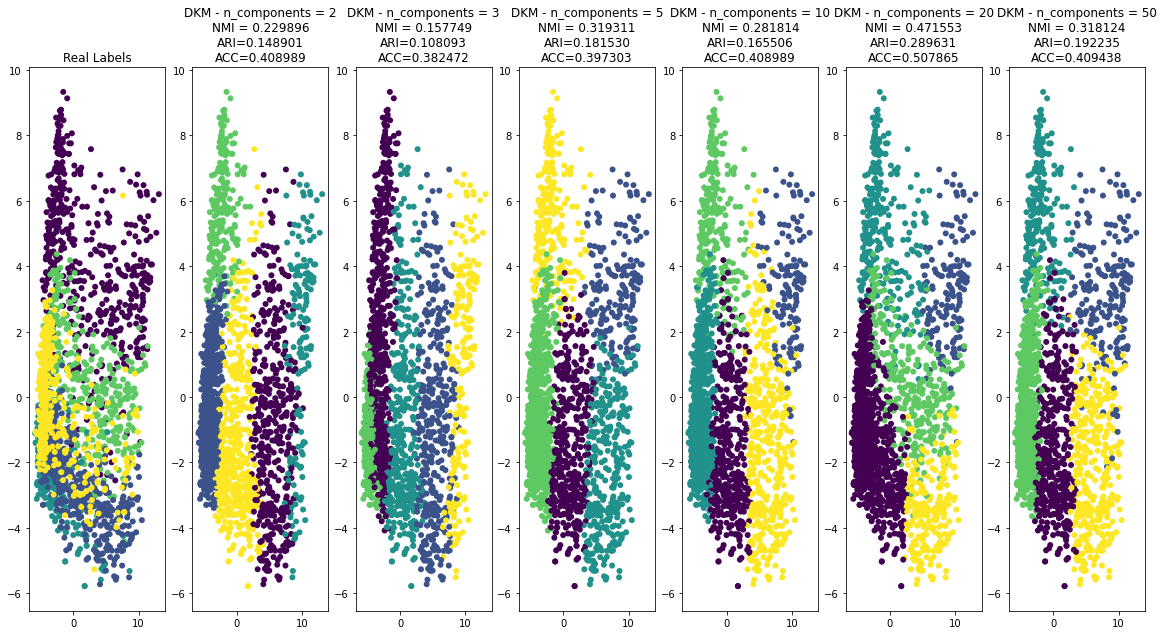

In [49]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
nmis, aris, accs = eval_clustering_2D(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

Pour la même représentation **word2vec** et en appliquant la méthode DKM avec différents nombre de composantes, on peut voir que la classification proposée avec 2 composantes est toujours dans les mêmes performances que celles du DCN, en augmentant l'ARI vers 0.3. On constate également qu'en augmentant le nombre de composantes à chaque fois ne fait que dégrader les perofrmances de la classification sur toutes les mesures.

In [50]:
key = '{}_{}_dkm'.format(dataset, rep)
bbc_resluts[key] = (nmis, aris, accs)

### Tableau des résultats

In [51]:
with open("/gdrive/My Drive/datasets/AMSD/projet_nadif/bbcpart2results.pkl", "wb") as results_file:
  pickle.dump(bbc_resluts, results_file)

In [52]:
BBC_results = {key: {inkey: {'nmi': nmi[inkey],'ari': ari[inkey],'acc': acc[inkey]} for inkey in nmi.keys()}  for key, (nmi, ari, acc) in bbc_resluts.items()}
bbc_results_dataframe = pd.DataFrame.from_dict({(i,j): BBC_results[i][j] 
                           for i in BBC_results.keys() 
                           for j in BBC_results[i].keys()},
                       orient='index')
bbc_results_dataframe

nmi       ari       acc
bbc_word2vec_dcn DCN - n_components = 2   0.589875  0.470124  0.646742
                 DCN - n_components = 3   0.688647  0.584526  0.676404
                 DCN - n_components = 5   0.765696  0.751815  0.893933
                 DCN - n_components = 10  0.789176  0.796012  0.913258
                 DCN - n_components = 20  0.820418  0.838265  0.930337
                 DCN - n_components = 50  0.807960  0.816775  0.922697
bbc_word2vec_dkm DKM - n_components = 2   0.641563  0.517976  0.652584
                 DKM - n_components = 3   0.710358  0.613475  0.686742
                 DKM - n_components = 5   0.723961  0.641600  0.686742
                 DKM - n_components = 10  0.832581  0.846094  0.934831
                 DKM - n_components = 20  0.874732  0.889530  0.953258
                 DKM - n_components = 50  0.843172  0.842409  0.932135
bbc_GloVe_dcn    DCN - n_components = 2   0.669825  0.673413  0.848989
                 DCN - n_components = 3   0.744139  0.758549  0.895730
                 DCN - n_components = 5   0.759896  0.781958  0.904719
                 DCN - n_components = 10  0.776213  0.795878  0.913258
                 DCN - n_components = 20  0.777060  0.787648  0.909663
                 DCN - n_components = 50  0.786954  0.812673  0.920000
bbc_GloVe_dkm    DKM - n_components = 2   0.687111  0.699271  0.861124
                 DKM - n_components = 3   0.750390  0.765288  0.898427
                 DKM - n_components = 5   0.776416  0.789088  0.908764
                 DKM - n_components = 10  0.805679  0.820366  0.924045
                 DKM - n_components = 20  0.833029  0.854293  0.937978
                 DKM - n_components = 50  0.822277  0.836325  0.930787
bbc_bert_dcn     DCN - n_components = 2   0.278450  0.178102  0.425169
                 DCN - n_components = 3   0.486310  0.348981  0.553258
                 DCN - n_components = 5   0.407828  0.313230  0.581573
                 DCN - n_components = 10  0.466808  0.378918  0.662472
                 DCN - n_components = 20  0.579770  0.552237  0.786067
                 DCN - n_components = 50  0.567832  0.543448  0.777978
bbc_bert_dkm     DKM - n_components = 2   0.432895  0.324447  0.549213
                 DKM - n_components = 3   0.486019  0.340368  0.555955
                 DKM - n_components = 5   0.508911  0.461501  0.693483
                 DKM - n_components = 10  0.520251  0.432261  0.691236
                 DKM - n_components = 20  0.590549  0.536242  0.759551
                 DKM - n_components = 50  0.492556  0.376100  0.613483
bbc_roberta_dcn  DCN - n_components = 2   0.092764  0.059984  0.326292
                 DCN - n_components = 3   0.124749  0.099550  0.324494
                 DCN - n_components = 5   0.334973  0.199918  0.404045
                 DCN - n_components = 10  0.317469  0.212835  0.431910
                 DCN - n_components = 20  0.423195  0.283500  0.515056
                 DCN - n_components = 50  0.316452  0.193452  0.410787
bbc_roberta_dkm  DKM - n_components = 2   0.229896  0.148901  0.408989
                 DKM - n_components = 3   0.157749  0.108093  0.382472
                 DKM - n_components = 5   0.319311  0.181530  0.397303
                 DKM - n_components = 10  0.281814  0.165506  0.408989
                 DKM - n_components = 20  0.471553  0.289631  0.507865
                 DKM - n_components = 50  0.318124  0.192235  0.409438

Meilleure méthode selon la métrique NMI:

In [53]:
metric = "nmi"
bbc_results_dataframe[bbc_results_dataframe[metric] == bbc_results_dataframe[metric].max()]

nmi      ari       acc
bbc_word2vec_dkm DKM - n_components = 20  0.874732  0.88953  0.953258

Meilleure méthode selon la métrique ARI:

In [54]:
metric = "ari"
bbc_results_dataframe[bbc_results_dataframe[metric] == bbc_results_dataframe[metric].max()]

nmi      ari       acc
bbc_word2vec_dkm DKM - n_components = 20  0.874732  0.88953  0.953258

Meilleure méthode selon la métrique l'Accuracy:

In [55]:
metric = "acc"
bbc_results_dataframe[bbc_results_dataframe[metric] == bbc_results_dataframe[metric].max()]

nmi      ari       acc
bbc_word2vec_dkm DKM - n_components = 20  0.874732  0.88953  0.953258

### Nuage des mots pour les différents clusters

On va afficher le nuage des points des clusters ayant donné les meilleurs résultats: 

Avec la méthode DKM, Représentation word2Vec, n_components=20

In [56]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
dataset, n_components, rep = 'bbc', 20, 'word2vec'
cluster_key = f'{dataset}_default{n_components}components_embed_{rep}'

Class: 16


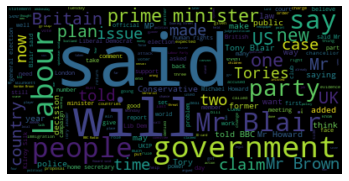



Class: 18


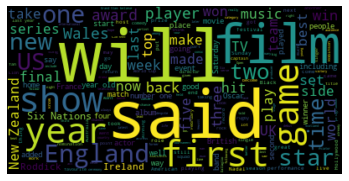



Class: 9


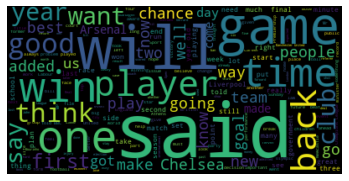



Class: 10


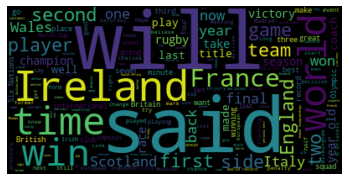



Class: 4


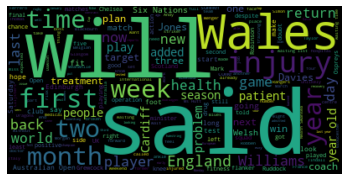



Class: 11


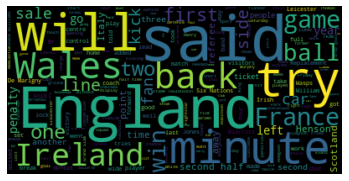



Class: 12


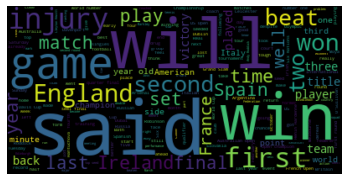



Class: 6


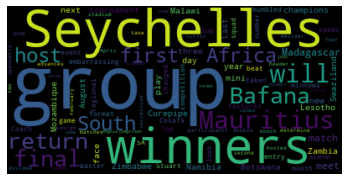



Class: 0


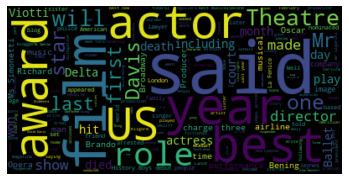



Class: 2


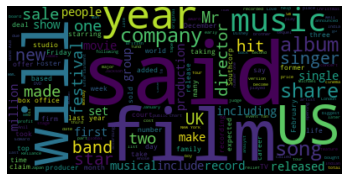



Class: 8


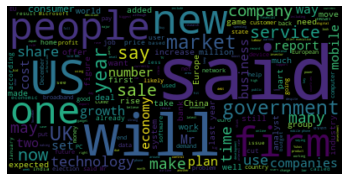



Class: 1


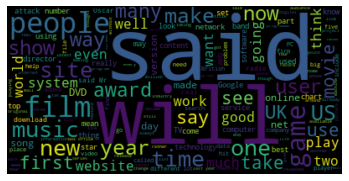



Class: 13


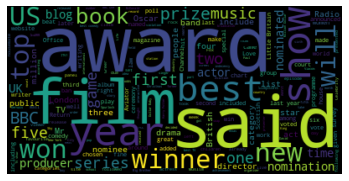



Class: 19


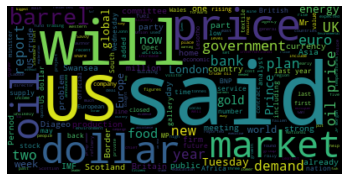



Class: 15


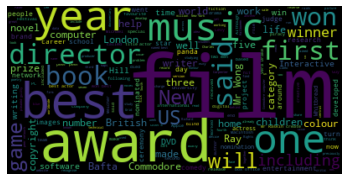



Class: 3


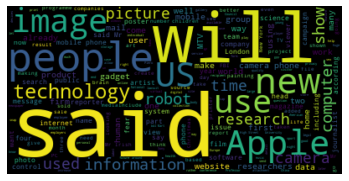



Class: 7


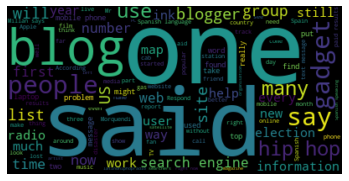



Class: 5


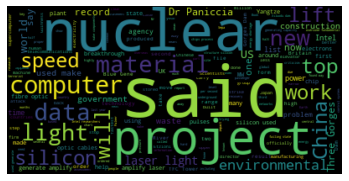



Class: 14


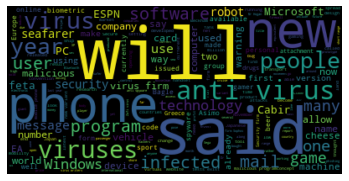

In [57]:
with h5.File(file_name, 'r') as alg_file:
  best_labels = alg_file[cluster_key]
  print_wordcloud(bbc_texts, np.array(best_labels).argmax(axis=1))

Le nuage des points de la dataset originale.

In [ ]:
print_wordcloud(bbc_texts, bbc_labels)

## Article 1

In [ ]:
dataset = 'article1'
article1_resluts = {}

### Word2Vec

In [ ]:
X = article1_word2vec
rep = 'word2vec'

#### DCN

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DCN_labels, DCN_methods)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DKM_labels, DKM_methods)

### GloVe

In [ ]:
X = article1_glove
rep = 'GloVe'

#### DCN

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DCN_labels, DCN_methods)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DKM_labels, DKM_methods)

### Bert

In [ ]:
X = article1_bert
rep = 'bert'

#### DCN

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DCN_labels, DCN_methods)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

### RoBertA

In [ ]:
X = article1_roberta
rep = 'roberta'

#### DCN

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

### Nuage des mots pour les différents clusters

On va afficher le nuage des points des clusters ayant donné les meilleurs résultats: 

Avec la méthode DKM, Représentation word2Vec, n_components=20

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
dataset, n_components, rep = 'article1', 20, 'word2vec'
cluster_key = f'{dataset}_default{n_components}components_embed_{rep}'

In [ ]:
with h5.File(file_name, 'r') as alg_file:
  best_labels = alg_file[cluster_key]
  print_wordcloud(bbc_texts, np.array(best_labels).argmax(axis=1))

## Article 2

In [ ]:
dataset = 'article2'
article2_resluts = {}

### Word2Vec

In [ ]:
X = article2_word2vec
rep = 'word2vec'

#### DCN

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DCN_labels, DCN_methods)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DKM_labels, DKM_methods)

### GloVe

In [ ]:
X = article2_glove
rep = 'GloVe'

#### DCN

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DCN_labels, DCN_methods)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DKM_labels, DKM_methods)

### Bert

In [ ]:
X = article2_bert
rep = 'bert'

#### DCN

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, DCN_labels, DCN_methods)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

### RoBertA

In [ ]:
X = article2_roberta
rep = 'roberta'

#### DCN

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dcn_file.h5'
DCN_labels, DCN_methods = run_methods(DCN, X, k, 'DCN', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, map_labels(labels), DCN_labels, DCN_methods)

#### DKM

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
DKM_labels, DKM_methods = run_methods(DKM, X, k, 'DKM', file_name, dataset, rep)

In [ ]:
X_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
eval_clustering_unlabeled(X_reduced, map_labels(labels), DKM_labels, DKM_methods)

### Nuage des mots pour les différents clusters

On va afficher le nuage des points des clusters ayant donné les meilleurs résultats: 

Avec la méthode DKM, Représentation word2Vec, n_components=20

In [ ]:
file_name = '/gdrive/My Drive/datasets/AMSD/projet_nadif/dkm_file.h5'
dataset, n_components, rep = 'articles', 20, 'word2vec'
cluster_key = f'{dataset}_default{n_components}components_embed_{rep}'

In [ ]:
with h5.File(file_name, 'r') as alg_file:
  best_labels = alg_file[cluster_key]
  print_wordcloud(bbc_texts, np.array(best_labels).argmax(axis=1))